## Using Word2Vec to Score Relatedness Between a Tweet and a Unigram Search Term
***

In [1]:
# Dataframe data structures
import pandas as pd

# Word2Vec functionality
from gensim.models import Word2Vec

# String manipulation libraries
import re
import string
from nltk.tokenize.casual import reduce_lengthening
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Math operations
from scipy.spatial.distance import cosine
from math import sqrt, cos, pi
from scipy.stats import norm
import numpy as np

# Scoring and evaluation
from sklearn.metrics import roc_auc_score, roc_curve

# Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Importing Tweet Data
***

In [2]:
columns = ['tweet_id', 'timestamp', 'tweet_text', 'user_id',
           'tweet_coords', 'tweet_coords_list', 'tweet_long', 'tweet_lat', 'location',
           'enc_url', 'tweet_lang', 'hashtags']
tweet_full = pd.read_csv(r'./tweetCoords.csv',
                         header = None,
                         names = columns,
                         parse_dates = [1],
                         index_col = 'timestamp')

In [3]:
tweet_date = pd.to_datetime("2017-09-10 00:00:00")
date_delta = pd.Timedelta("24HR")

In [4]:
tweet_full_en = tweet_full[tweet_full['tweet_lang'] == 'en']

In [5]:
tweet_text = tweet_full_en.loc[tweet_date:tweet_date + date_delta, "tweet_text"]

### Helper Functions
***

In [6]:
tweet_stops = stopwords.words('english')
stemmer = PorterStemmer()

def clean_tweet(tweet):
## takes input string and converts or removes characters depending on settings.
## returns a string
## convert case:
    tweet = tweet.lower()
## remove URLs:
    tweet = re.sub('https?://\S+', '', tweet)
## remove @mentions, including those with a leading '-' or '.' : 
    tweet = re.sub('[-\.]?@\w+', '', tweet)
## convert non-hashtag punctuation to whitespace:
    tweet = tweet.translate(tweet.maketrans(string.punctuation.replace("#", ""), " "*len(string.punctuation.replace("#", ""))))
## remove non-hashtag '#'.
    tweet = re.sub('\B#\B', '', tweet)
## remove 'amp', 'gt', 'lt', indicating decoded ampersand, greater-than, less-than characters
    tweet = re.sub(r'\b(amp|gt|lt)\b', '', tweet)
## remove non-hashtag numbers    
    tweet = re.sub(r'\b(?<!#)\d+\b', '', tweet)
    return tweet

def tokens_no_stopwords(tweet_as_string):
# wrapper function that combines the tokenizer, cleaner, and stopword removal.
# takes a string and returns a list of strings
    cleaned_tweet = clean_tweet(tweet_as_string)
    tweet_reduce_len = reduce_lengthening(cleaned_tweet)
# tweet_as_tokens = word_tokenize(tweet_reduce_len)
    tweet_as_tokens = tweet_reduce_len.split()
    tweet_no_stops = [stemmer.stem(word) for word in tweet_as_tokens if word not in tweet_stops]
    
    return tweet_no_stops

### Miscellaneous Tests:
***

In [7]:
punc_test = "This is some (&) text$that has &*char$ in it"
punc_test.translate(punc_test.maketrans(string.punctuation.replace("#", ""), " "*len(string.punctuation.replace("#", ""))))

'This is some     text that has   char  in it'

In [8]:
punc_test.translate(punc_test.maketrans('', '', string.punctuation.replace("#", "")))

'This is some  textthat has char in it'

In [9]:
re_hash_test = '# #34 4#3 A#36 3 A# #hashtag'
print(re.sub(r'\b#\B', '!', re_hash_test))
print(re.sub(r'\b#\b', '!', re_hash_test))
print(re.sub(r'\B#\B', '!', re_hash_test))

# #34 4#3 A#36 3 A! #hashtag
# #34 4!3 A!36 3 A# #hashtag
! #34 4#3 A#36 3 A# #hashtag


In [10]:
text = "this is a tweet # #### ####1 #hashtag #123 #12345 apm yooooo"
tokens_no_stopwords(text)

['tweet', '#1', '#hashtag', '#123', '#12345', 'apm', 'yooo']

In [11]:
ex_text = "OOOOMMMMGGGGG This is the #1 worst THING HAPPENING IN 2017!!!!!! Power is out & Basement is flooded! #irma #hurricane @TV9 @my_friend https://my.domain.net"

In [12]:
tweet_test = ex_text
print(tweet_test)
tweet_test = tweet_test.lower()
print(tweet_test.split())
i = 0
print(f"S: {tweet_test}"); i += 1

# 1: remove URLs:
tweet_test = re.sub('https?://\S+', '', tweet_test)
print(f"{i}: {tweet_test}"); i += 1

# 2: remove @mentions, including those with a leading '-' or '.' : 
tweet_test = re.sub('[-\.]?@\w+', '', tweet_test)
print(f"{i}: {tweet_test}"); i += 1

# 3: remove punctuation, but not hashtags:
tweet_test = tweet_test.translate(tweet_test.maketrans('', '', string.punctuation.replace("#", "")))
print(f"{i}: {tweet_test}"); i += 1

# 4: remove non-hashtag '#'.
tweet_test = re.sub('#\B', '', tweet_test)
print(f"{i}: {tweet_test}"); i += 1

# 5: remove 'amp', 'gt', 'lt', indicating decoded ampersand, greater-than, less-than characters
tweet_test = re.sub(r'\b(amp|gt|lt)\b', '', tweet_test)
print(f"{i}: {tweet_test}"); i += 1

# 6: drop numbers, but not hashtags
tweet_test = re.sub(r'\b(?<!#)\d+\b', '', tweet_test)
print(f"{i}: {tweet_test}"); i += 1


print(tokens_no_stopwords(tweet_test))

OOOOMMMMGGGGG This is the #1 worst THING HAPPENING IN 2017!!!!!! Power is out & Basement is flooded! #irma #hurricane @TV9 @my_friend https://my.domain.net
['oooommmmggggg', 'this', 'is', 'the', '#1', 'worst', 'thing', 'happening', 'in', '2017!!!!!!', 'power', 'is', 'out', '&', 'basement', 'is', 'flooded!', '#irma', '#hurricane', '@tv9', '@my_friend', 'https://my.domain.net']
S: oooommmmggggg this is the #1 worst thing happening in 2017!!!!!! power is out & basement is flooded! #irma #hurricane @tv9 @my_friend https://my.domain.net
1: oooommmmggggg this is the #1 worst thing happening in 2017!!!!!! power is out & basement is flooded! #irma #hurricane @tv9 @my_friend 
2: oooommmmggggg this is the #1 worst thing happening in 2017!!!!!! power is out & basement is flooded! #irma #hurricane   
3: oooommmmggggg this is the #1 worst thing happening in 2017 power is out  basement is flooded #irma #hurricane   
4: oooommmmggggg this is the #1 worst thing happening in 2017 power is out  basement

In [13]:
tweet_len = tweet_text.groupby(tweet_text.str.split().apply(len)).size()

In [14]:
tweet_len_post = tweet_text.apply(tokens_no_stopwords).apply(len).value_counts().sort_index()

In [15]:
plt.style.use('bmh')
plt.rc('text', usetex = True)
plt.rc('font', family = 'serif')
plt.rcParams.update({'font.size': 22})

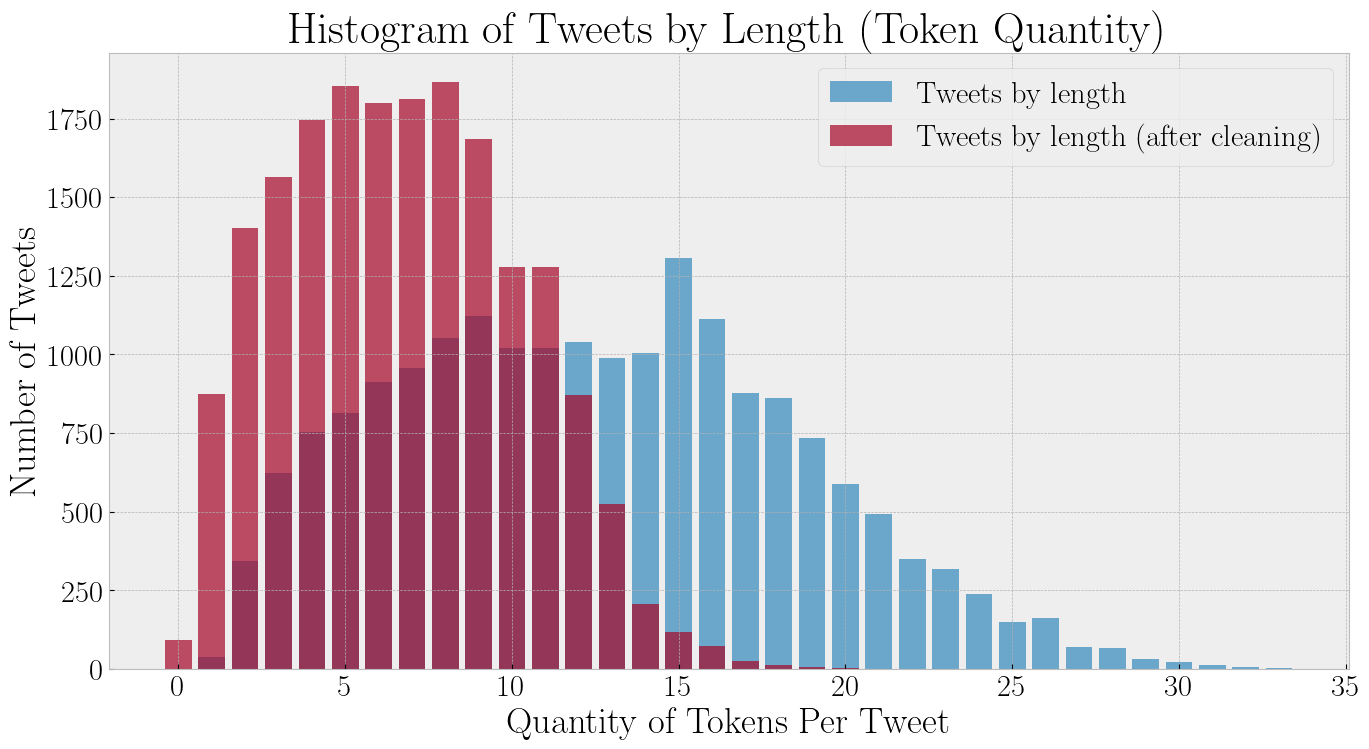

In [16]:
fig_tweet_hist = plt.figure(figsize = (16, 8))
plt.bar(tweet_len.index, tweet_len.values, alpha = .7, label = "Tweets by length")
plt.bar(tweet_len_post.index, tweet_len_post.values, alpha = .7, label = "Tweets by length (after cleaning)")
plt.xlabel("Quantity of Tokens Per Tweet")
plt.ylabel("Number of Tweets")
plt.title("Histogram of Tweets by Length (Token Quantity)")
plt.legend()
plt.show()

## Skip-Gram Analysis

### Search Term

In [17]:
search_term = 'irma'

In [18]:
coded_tweets = pd.read_csv(r'./irmaTextCoding.csv')

tweets_on_date = tweet_full_en.loc[tweet_date:tweet_date+date_delta]

tweet_encoded = pd.concat([coded_tweets.reset_index(), tweets_on_date.iloc[:-1].reset_index()], axis = 1)

### Comparison Functions

Defines comparisons and a wrapper function that calls each based upon an associated keyword

- Mean Cosine Similarity
- Sum Cosine Similarity Over Square Root of Length
- Dot Product of Tweet As Matrix Sum of Term Vectors and Search Term
- Cosine Similarity of Tweet As Matrix Sum of Term Vectors and Search Term

In [19]:
def meanCosSim(tweet, vector_set):
    tweet_as_terms = tokens_no_stopwords(tweet)
    score = 0
    for i in tweet_as_terms:
        if i in list(vector_set.wv.index_to_key):
            score += vector_set.wv.similarity(i, search_term)
    if len(tweet_as_terms) > 0:
        score /= len(tweet_as_terms)
    else:
        score = 0
    return score

In [20]:
def sumCosSimSqrtSum(tweet, vector_set):
    tweet_as_terms = tokens_no_stopwords(tweet)
    score = 0
    for i in tweet_as_terms:
        if i in list(vector_set.wv.index_to_key):
            score += vector_set.wv.similarity(i, search_term)
    if len(tweet_as_terms) > 0:
        score /= sqrt(len(tweet_as_terms))
    else:
        score = 0
    return score

In [21]:
def dotProductOfTweetMatrixTermVector(tweet, vector_set):
    tweet_as_terms = tokens_no_stopwords(tweet)
# initialize vector with dimensionality of the vector set.
    vector_dim = len(vector_set.wv.vectors[0])
    score_matrix = np.zeros(vector_dim, ) 
    
# iterate over each word after processing. If the word is in the vocabulary,
# add its vector's value to the score matrix.
# this essentially treats a word not in the vocabulary as a zero-vector.
    for i in tweet_as_terms:
        if i in list(vector_set.wv.index_to_key):
            score_matrix = np.add(score_matrix, vector_set.wv.get_vector(i))
            
# if the number of words remaining in the tweet after processing is equal to zero, return zero.
# otherwise, take the dot product of the score vector, and the vector of the search term.
    if len(tweet_as_terms) > 0:
        score = np.dot(score_matrix, vector_set.wv.get_vector(search_term))
    else:
        score = 0
    return score

In [22]:
def cosSimOfTweetMatrixTermVector(tweet, vector_set):
    tweet_as_terms = tokens_no_stopwords(tweet)
    
# initialize vector with dimensionality of the vector set.
    vector_dim = len(vector_set.wv.vectors[0])
    score_matrix = np.zeros(vector_dim, )
    
# iterate over each word after processing. If the word is in the vocabulary,
# add its vector's value to the score matrix.
# this essentially treats a word not in the vocabulary as a zero-vector.
    for i in tweet_as_terms:
        if i in list(vector_set.wv.index_to_key):
            score_matrix = np.add(score_matrix, vector_set.wv.get_vector(i))

# if the number of words remaining in the tweet after processing is equal to zero, return zero.
# otherwise, take the pairwise cosine of the score vector and the vector of the search term.
    if ((len(tweet_as_terms) > 0) & (np.all(score_matrix != np.zeros(vector_dim, )))):
        score = 1 - cosine(score_matrix, vector_set.wv.get_vector(search_term))
    else:
        score = 0
    return score

Wrapper Function for the scalar comparison formulas:

In [23]:
def scalarFunctions(tweet, vector_set, formula = 'dp'):
    if(formula.upper() == 'DP'):
        return dotProductOfTweetMatrixTermVector(tweet, vector_set)
    elif(formula.upper() == 'MCS'):
        return meanCosSim(tweet, vector_set)
    elif(formula.upper() == 'SCSSC'):
        return sumCosSimSqrtSum(tweet, vector_set)
    elif(formula.upper() == 'CSTVS'):
        return cosSimOfTweetMatrixTermVector(tweet, vector_set)
    else:
        return np.NaN

This is the code training the vector model with optimal hyperparameter values

In [24]:
# taking values from iterative test
HD = 150
MWC = 5
WWS = 1
NS = 1
EP = 25
tweet_text = tweet_full_en.loc[tweet_date:tweet_date + date_delta, "tweet_text"]
tweets_tokens = tweet_text.apply(tokens_no_stopwords)

opt_vector_model = Word2Vec(tweets_tokens, min_count = MWC, window = WWS, workers = 1, vector_size = HD, seed = 1, sg = 1, negative = NS)
    
# train the model over 10 epochs
opt_vector_model.train(tweets_tokens, total_examples = len(tweet_text), epochs = EP)

(2482287, 3224100)

### AU-ROC Score

In [25]:
# Optimal parameters for Word2Vec:
for i in ['dp', 'mcs', 'scssc', 'cstvs']:
# create strings for column heads
    sw = f'o-sw-{i}'
    mmsw = f'MM-{sw}'
    
# Scoring tweets in this column:
    tweet_encoded[sw] = tweet_encoded.tweet_text.apply(scalarFunctions, args = (opt_vector_model, i))
                                                       
# column of scores for this iteration|
    tweet_scores = tweet_encoded[sw]

# calculating Min Max Scaling for this column 
    tweet_encoded[mmsw] = ((tweet_scores - tweet_scores.min())* 100) / (tweet_scores.max() - tweet_scores.min())

Graphs for Paper

In [26]:
plt.rc('text', usetex = True)
plt.rc('font', family = 'serif')
plt.rcParams.update({'font.size': 22})

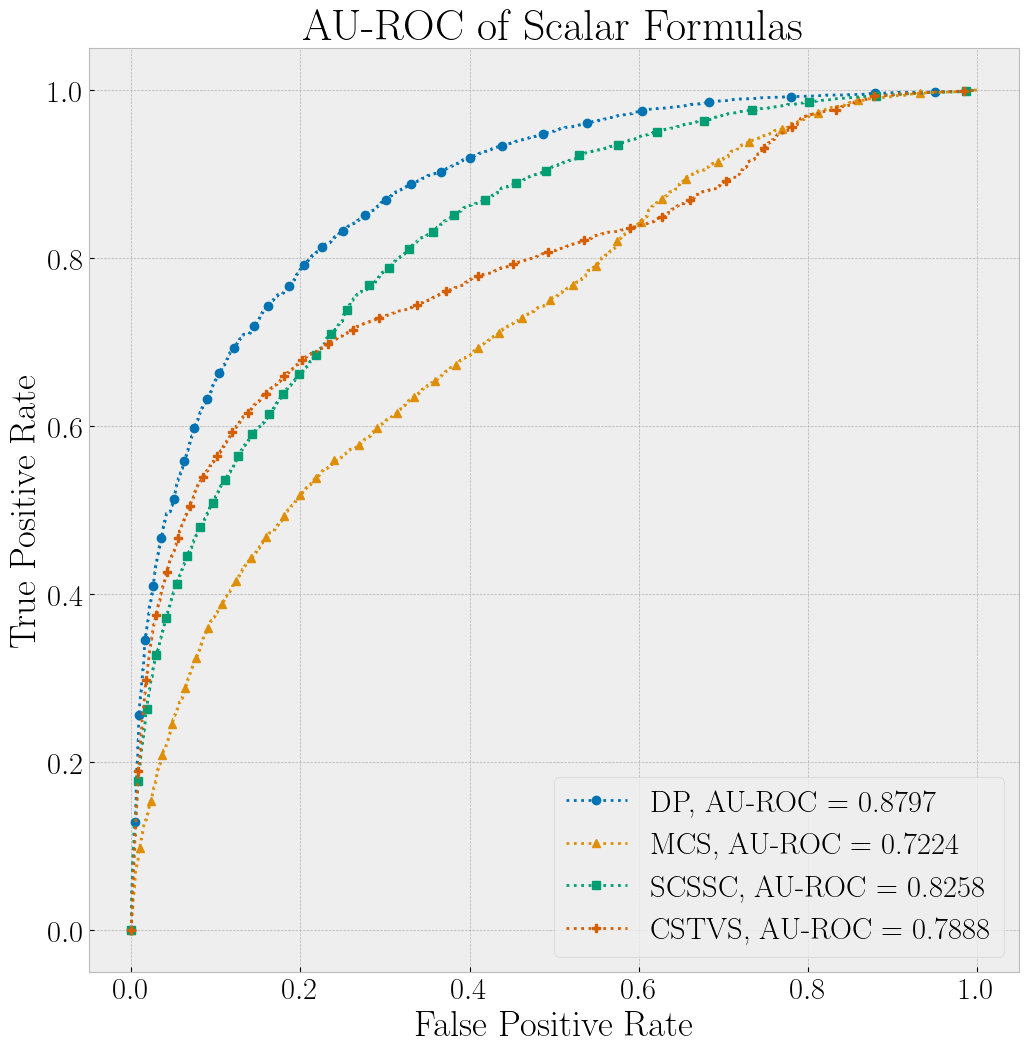

In [27]:
sns.set_palette('colorblind')
fig_roc_s = plt.figure(figsize = (12, 12), dpi = 100, facecolor = 'w')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

# line_list = {'d':":", 'o':":"}
marker_list = {'dp':'o', 'mcs':'^', 'scssc':'s', 'cstvs':'P'}
j = 'o'
for i in ['dp', 'mcs', 'scssc', 'cstvs']:

    fpr, tpr, thresholds = roc_curve(tweet_encoded['irma_rel'], tweet_encoded[f'MM-{j}-sw-{i}'])
    auroc_score = round(roc_auc_score(tweet_encoded['irma_rel'], tweet_encoded[f'MM-o-sw-{i}']), 4)
    label_text = f"{i.upper()}, AU-ROC = {auroc_score}"

    plt.plot(fpr, tpr, label = label_text, linestyle = ":", marker = marker_list.get(i), markevery = 200)

plt.title("AU-ROC of Scalar Formulas")
plt.legend(loc = "lower right")
plt.show()

In [28]:
tweet_times = tweet_encoded.set_index('timestamp')

In [29]:
tweet_times['oSWDPStd'] = (tweet_times['o-sw-dp'] - tweet_times['o-sw-dp'].mean())/tweet_times['o-sw-dp'].std()

In [30]:
tweet_times['oSWDPStdMM'] = ((tweet_times['oSWDPStd'] - tweet_times['oSWDPStd'].min())* 100) / (tweet_times['oSWDPStd'].max() - tweet_times['oSWDPStd'].min())

In [31]:
tweet_times['MMoDPNormStd']  = (tweet_times['MM-o-sw-dp'] - tweet_times['MM-o-sw-dp'].mean())/tweet_times['MM-o-sw-dp'].std()

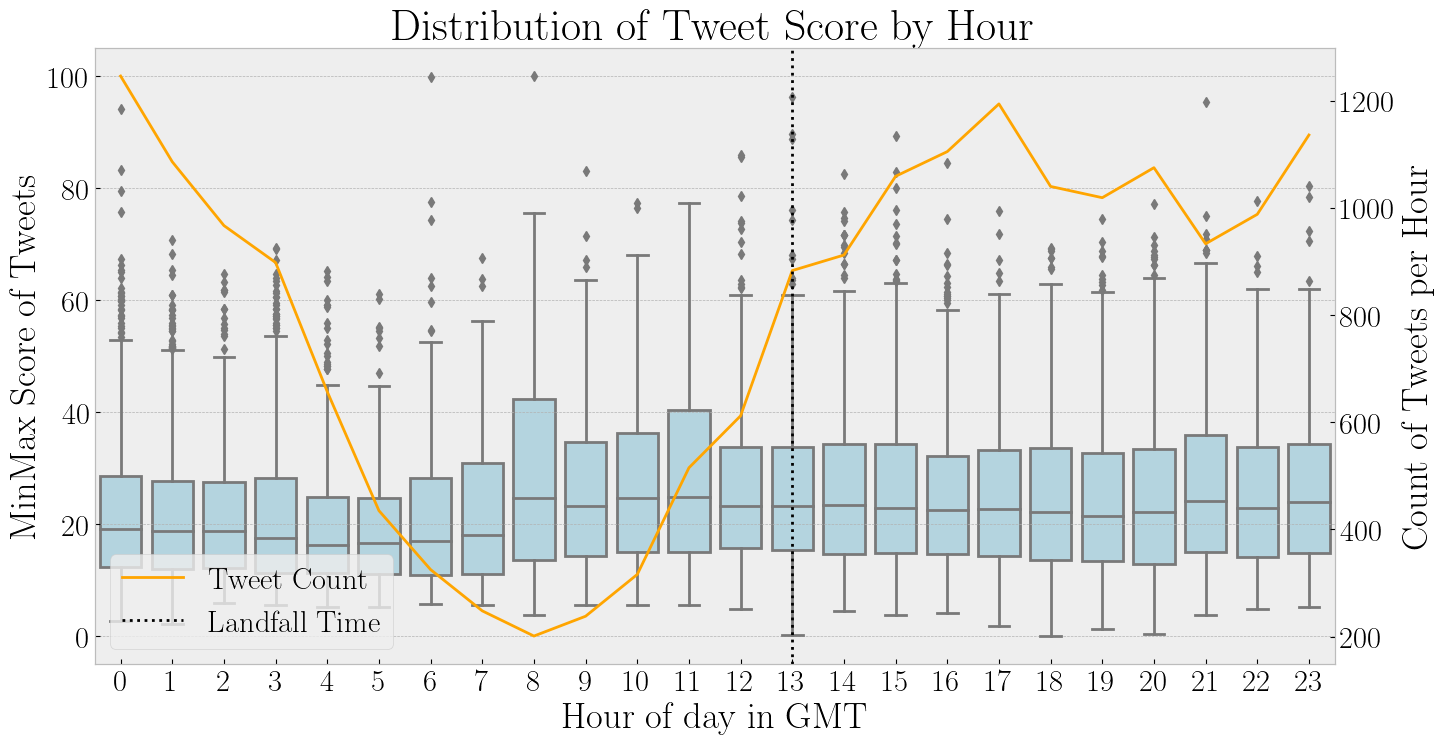

In [32]:
fig = plt.figure(figsize = (16, 8))

ax1 = fig.add_subplot()

sns.boxplot(x = tweet_times.index.hour, y = tweet_times['oSWDPStdMM'], color = 'lightblue')

ax1.set_xlabel('Hour of day in GMT')
ax1.set_ylabel('MinMax Score of Tweets')
ax1.set_title('Distribution of Tweet Score by Hour')
ax2 = ax1.twinx()
ax2.plot(tweet_times.groupby(tweet_times.index.hour).count().iloc[:,0], label = 'Tweet Count', color = 'orange')
ax2.set_ylabel('Count of Tweets per Hour')
ax2.axvline(x = 13, label = 'Landfall Time', linestyle = ':', color = 'black')
ax2.grid(visible = False)
ax2.legend()
plt.show()